# Import das bibliotecas

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter

# Estilização do Seaborn

In [2]:
sns.set(style="whitegrid")

# Conexão com o Bando de Dados

In [53]:
def connect_to_db(host, port, user, password, db_name):
    conn = pymysql.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=db_name
    )
    return conn

host = 'localhost'  
port = 3306  
user = 'root'  
password = 'hanglose1'  
db_name = 'Docentify'  


conn = connect_to_db(host, port, user, password, db_name)



# Query para carregar os dados

In [16]:
query = """
SELECT 
    U.name AS Nome, 
    C.name AS Curso, 
    E.enrollmentDate AS Data_Inscricao, 
    UP.progressDate AS Data_Progresso, 
    S.description AS Etapa
FROM Users U
JOIN Enrollments E ON U.id = E.userId
JOIN Courses C ON E.courseId = C.id
JOIN UserProgress UP ON E.id = UP.enrollment_id
JOIN Steps S ON UP.stepId = S.id
ORDER BY U.name, C.name, UP.progressDate;
"""

df_progress = pd.read_sql(query, conn)


/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/1308495023.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_progress = pd.read_sql(query, conn)


# Tratamento de dados

In [17]:
# Garante que todos os usuários estejam no gráfico, mesmo se não houver progresso
todos_os_usuarios = df_progress['Nome'].unique()

# Agrupa e soma o progresso ao longo do tempo
df_progress_grouped = df_progress.groupby(['Data_Progresso', 'Nome']).size().reset_index(name='Total_Progresso')

# Garante que todos os usuários estejam representados na tabela, preenchendo progresso ausente com 0
df_progress_grouped_pivot = df_progress_grouped.pivot_table(index='Data_Progresso', columns='Nome', values='Total_Progresso').reindex(columns=todos_os_usuarios, fill_value=0).reset_index()

# Transforma a tabela pivotada para formato longo
df_progress_long = df_progress_grouped_pivot.melt(id_vars=['Data_Progresso'], var_name='Nome', value_name='Progresso_Acumulado')


# SQL para contar quantos usuários estão inscritos em cada curso

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/4161877547.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_courses = pd.read_sql(query_courses, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/4161877547.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Inscritos', y='Curso', data=df_courses, palette='coolwarm')


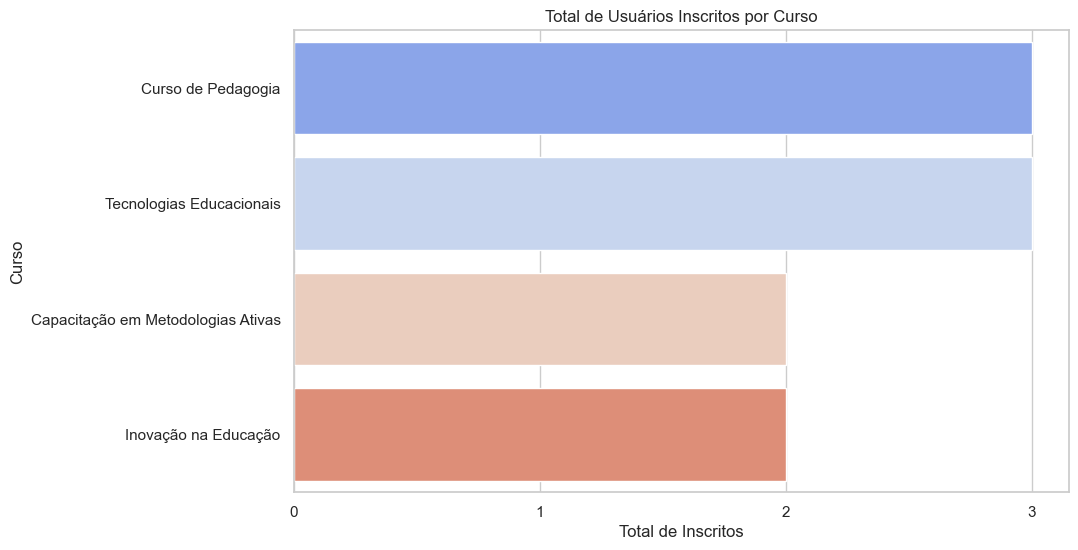

In [35]:
query_courses = """
SELECT c.name AS Curso, COUNT(e.userId) AS Total_Inscritos
FROM Enrollments e
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""

df_courses = pd.read_sql(query_courses, conn)

plt.figure(figsize=(10,6))
plt.xticks(ticks=range(0, df_courses['Total_Inscritos'].max() + 1, 1))
sns.barplot(x='Total_Inscritos', y='Curso', data=df_courses, palette='coolwarm')
plt.title('Total de Usuários Inscritos por Curso')
plt.xlabel('Total de Inscritos')
plt.ylabel('Curso')
plt.show()


# Progresso Acumulado dos Usuários ao Longo do Tempo

<Figure size 1600x800 with 0 Axes>

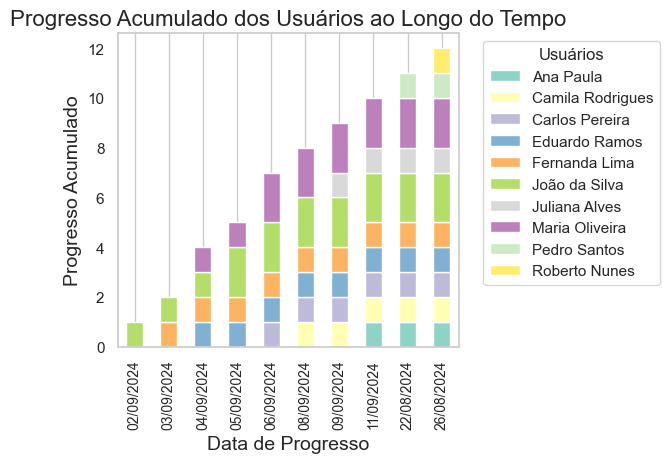

In [45]:
df_progress['Data_Progresso'] = pd.to_datetime(df_progress['Data_Progresso'], dayfirst=True).dt.strftime('%d/%m/%Y')

df_progress_grouped = df_progress.groupby(['Data_Progresso', 'Nome']).size().unstack(fill_value=0).cumsum()

plt.figure(figsize=(16,8)) 

df_progress_grouped.plot(kind='bar', stacked=True, colormap='Set3')

plt.title('Progresso Acumulado dos Usuários ao Longo do Tempo', fontsize=16)
plt.xlabel('Data de Progresso', fontsize=14)
plt.ylabel('Progresso Acumulado', fontsize=14)
plt.xticks(rotation=90, fontsize=10)

# Define a legenda fora do gráfico
plt.legend(title='Usuários', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


# Consulta SQL para obter o total de finalizações por curso (Popularidade)

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/2324655200.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_popularity = pd.read_sql(query_popularity, conn)


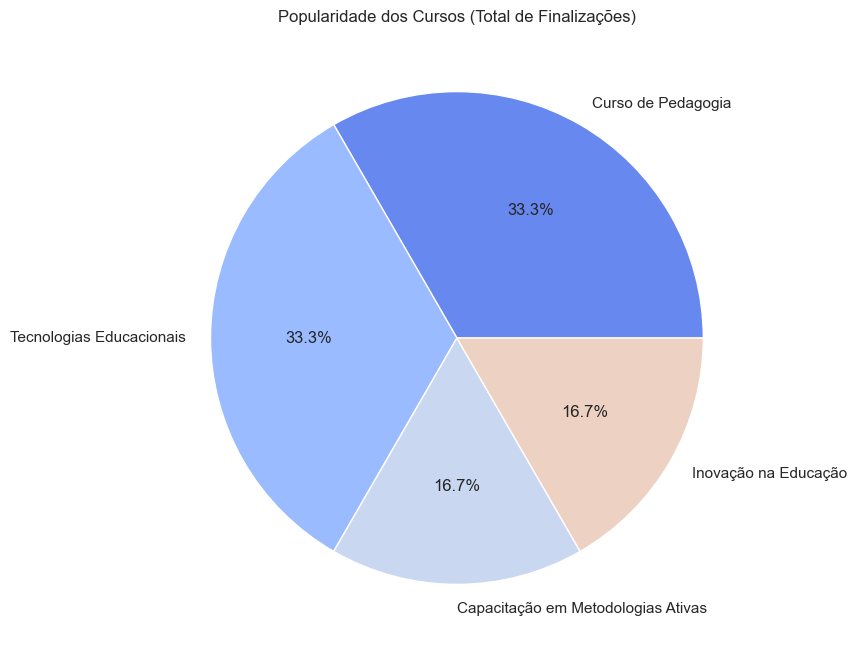

In [46]:
query_popularity = """
SELECT c.name AS Curso, COUNT(up.progressDate) AS Total_Finalizados
FROM UserProgress up
JOIN Enrollments e ON up.enrollment_id = e.id
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""

df_popularity = pd.read_sql(query_popularity, conn)

plt.figure(figsize=(8,8))
plt.pie(df_popularity['Total_Finalizados'], labels=df_popularity['Curso'], autopct='%1.1f%%', colors=sns.color_palette('coolwarm'))
plt.title('Popularidade dos Cursos (Total de Finalizações)')
plt.show()


# Consulta SQL para obter o progresso individual dos usuários

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/727916639.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_individual_progress = pd.read_sql(query_individual_progress, conn)


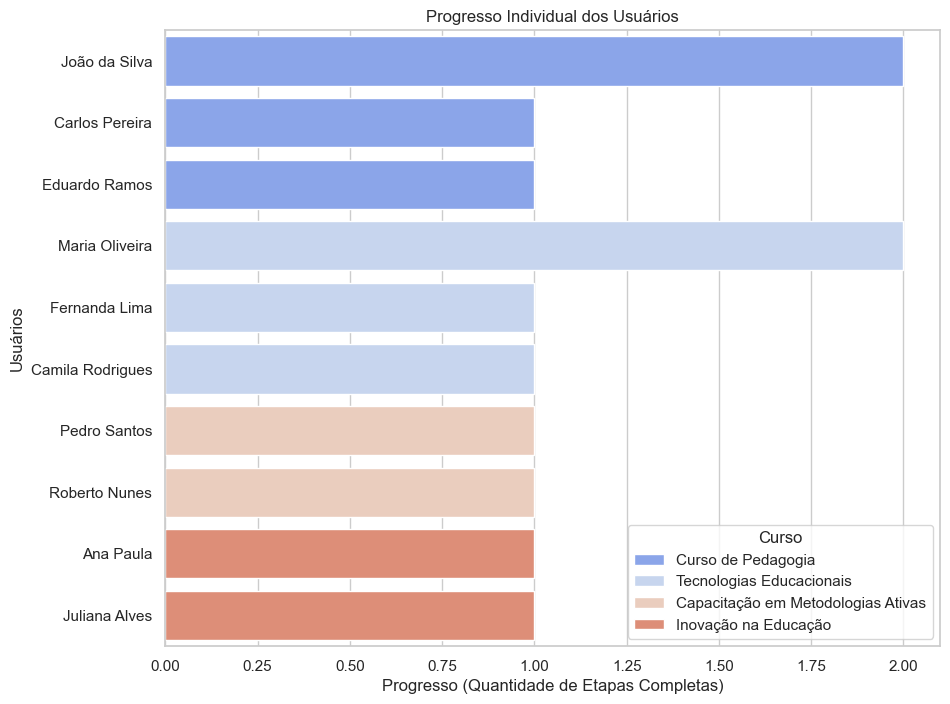

In [47]:
query_individual_progress = """
SELECT u.name AS Nome, c.name AS Curso, COUNT(up.stepId) AS Progresso
FROM UserProgress up
JOIN Enrollments e ON up.enrollment_id = e.id
JOIN Users u ON e.userId = u.id
JOIN Courses c ON e.courseId = c.id
GROUP BY u.name, c.name
"""

df_individual_progress = pd.read_sql(query_individual_progress, conn)

plt.figure(figsize=(10,8))
sns.barplot(x='Progresso', y='Nome', hue='Curso', data=df_individual_progress, palette='coolwarm')
plt.title('Progresso Individual dos Usuários')
plt.xlabel('Progresso (Quantidade de Etapas Completas)')
plt.ylabel('Usuários')
plt.show()


# Consulta SQL para obter o desempenho médio por curso

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/962055953.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_benchmarking = pd.read_sql(query_benchmarking, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/962055953.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Media_Desempenho', y='Curso', data=df_benchmarking, palette='coolwarm')


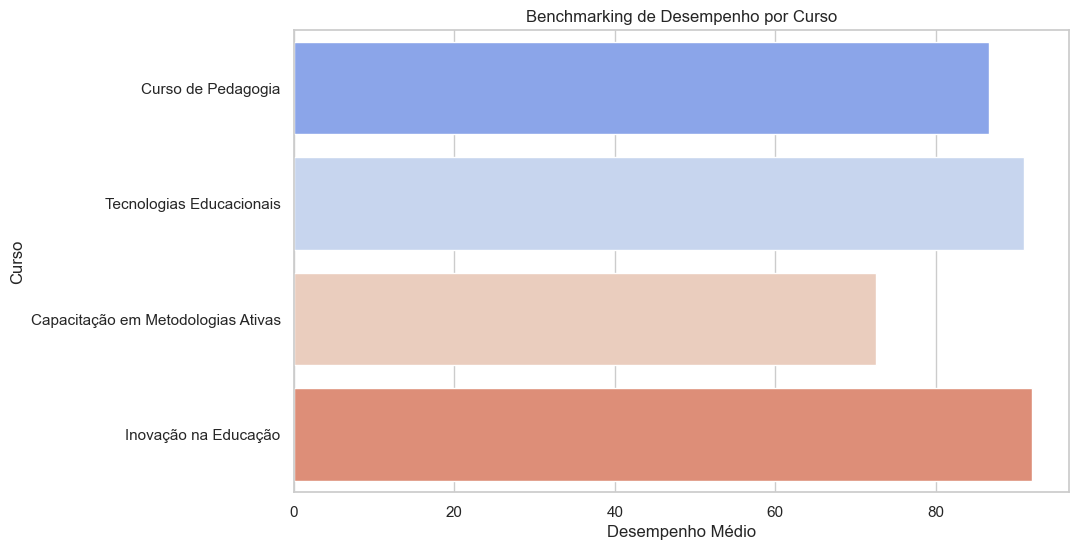

In [48]:
query_benchmarking = """
SELECT c.name AS Curso, AVG(us.score) AS Media_Desempenho
FROM UserScores us
JOIN Enrollments e ON us.userId = e.userId
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""

df_benchmarking = pd.read_sql(query_benchmarking, conn)

plt.figure(figsize=(10,6))
sns.barplot(x='Media_Desempenho', y='Curso', data=df_benchmarking, palette='coolwarm')
plt.title('Benchmarking de Desempenho por Curso')
plt.xlabel('Desempenho Médio')
plt.ylabel('Curso')
plt.show()


# Relatório de benchmarking de desempenho

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/3989914675.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_benchmark = pd.read_sql(query, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_1564/3989914675.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Usuario', y='Etapas_Completadas', data=df_benchmark, palette='viridis')


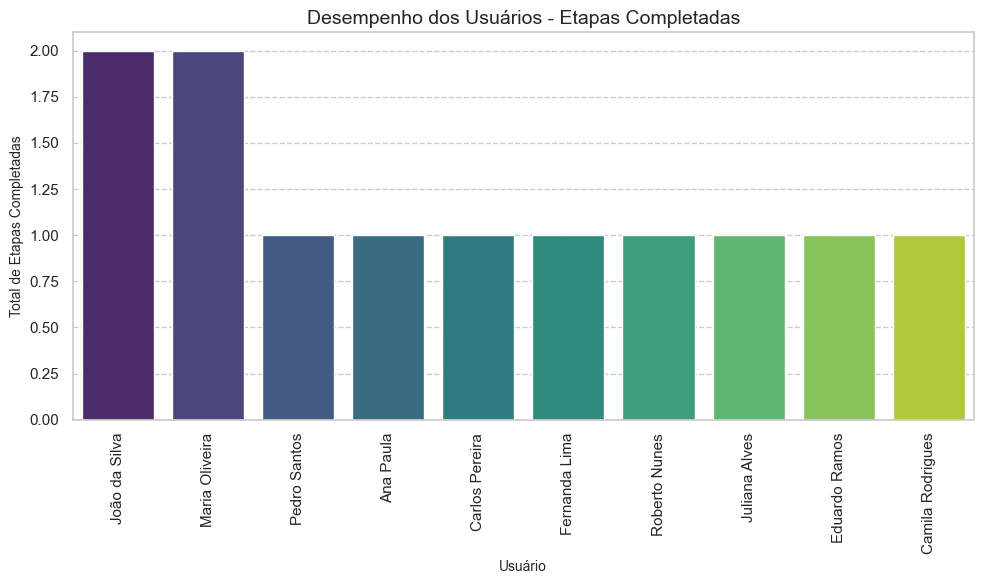

In [51]:
query = """
    SELECT U.name AS Usuario, COUNT(UP.stepId) AS Etapas_Completadas
    FROM Users U
    JOIN Enrollments E ON U.id = E.userId
    JOIN UserProgress UP ON E.id = UP.enrollment_id
    GROUP BY U.name
"""
df_benchmark = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x='Usuario', y='Etapas_Completadas', data=df_benchmark, palette='viridis')

plt.title('Desempenho dos Usuários - Etapas Completadas', fontsize=14)
plt.xlabel('Usuário', fontsize=10)
plt.ylabel('Total de Etapas Completadas', fontsize=10)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--')

plt.tight_layout()
plt.show()



In [54]:
df_benchmark.to_csv('relatorio_benchmark.csv', index=False)
print("Relatório exportado como CSV.")

Relatório exportado como CSV.


In [55]:
# Exportar para Excel
df_benchmark.to_excel('relatorio_benchmark.xlsx', index=False)
print("Relatório exportado como Excel.")

Relatório exportado como Excel.


In [52]:
conn.close()